# Real Data

In [1]:
import math
import simpy
import random
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, Point, LineString, MultiLineString

import warnings
warnings.filterwarnings("ignore")

In [2]:
### load data ###
T = np.load('data/T_matrix.npy')
zone_gdf = gpd.read_file('data/zone_5_gdf.geojson')

mu = 0.016328352042494592
lambda_list = [0.02890886287625418,
               0.022337188777406168,
               0.04395438498699368,
               0.020209726867335562,
               0.027751068376068375,
               0.02030030657748049,
               0.020007664437012265,
               0.02714023597175771,
               0.02780680973615756,
               0.024410070605722776,
               0.01329083054626533,
               0.02157074507617986]

In [3]:
def are_adjacent(region1, region2):
    """
    Check if two regions are adjacent using shapely.
    """
    poly1 = shape(region1)
    poly2 = shape(region2)
    
    return type(poly1.intersection(poly2)) is MultiLineString or type(poly1.intersection(poly2)) is LineString # share a border

def plot_boundary(df, beat_list, ax):
    df['idx'] = range(len(df))
    # Define a specific index for rows that match any BEAT value in the list
    specific_index = max(df['idx']) + 1  # This ensures the index is unique
    # Assign this specific index to rows where 'BEAT' matches any value in the beat_list
    df.loc[df['BEAT'].isin(beat_list), 'idx'] = specific_index

    # Plotting
    df.dissolve(by='idx').boundary.plot(ax=ax, linewidth=1, color='gray', alpha=1)
    df.dissolve(by='BEAT_first_digit').boundary.plot(ax=ax, linewidth=3, color='red')

def plot_filtered_gdf_with_arrows(gdf, beats, neighbours, ax):
    """
    Filters the GeoDataFrame based on a list of BEAT values, dissolves the result, 
    and plots it on the provided axes. Also, draws arrows from the centroid of the 
    dissolved geometry to the centroids of neighboring beats.

    :param gdf: The input GeoDataFrame.
    :param beats: List of BEAT values to filter by.
    :param neighbours: List of neighboring BEAT values to draw arrows to.
    :param ax: The Matplotlib axes to plot on.
    """
    # Filter the GeoDataFrame
    gdf_filtered = gdf[gdf['BEAT'].isin(beats)]

    # Dissolve the filtered GeoDataFrame
    gdf_dissolved = gdf_filtered.dissolve()

    # Plotting
    gdf_dissolved.boundary.plot(ax=ax, linewidth=4, color='white', alpha=1, linestyle='-')  # Solid white border
    gdf_dissolved.boundary.plot(ax=ax, linewidth=3, color='blue', linestyle='--')  # Dashed blue border
    gdf_dissolved.plot(ax=ax, color='gray', legend=False, alpha=0.5)

    # Calculate the centroid of the dissolved geometry
    dissolved_centroid = gdf_dissolved.geometry.centroid.iloc[0]

    # Draw arrows to neighboring beats
    for beat in neighbours:
        # Filter to get the geometry of the neighbor beat
        neighbour_geom = gdf[gdf['BEAT'] == beat].geometry.centroid.iloc[0]
        
        # Draw an arrow from dissolved centroid to neighbor centroid
        arrow_style = "->"
        ax.annotate('', xy=(neighbour_geom.x, neighbour_geom.y), xytext=(dissolved_centroid.x, dissolved_centroid.y),
                    arrowprops=dict(color='blue', arrowstyle=arrow_style, facecolor='black', lw=1))

In [4]:
### Select Districting Plan ###

### Plan g ###
# overlap_beats = []
# neighbours_list = []

### Plan a ###
# overlap_beats = [[503]]
# neighbours_list = [[502]]

### Plan b ###
# overlap_beats = [[503]]
# neighbours_list = [[502, 501]]

### Plan c ###
# overlap_beats = [[503]]
# neighbours_list = [[502, 501, 504, 505]]

### Plan d ###
# overlap_beats = [[503], [511]]
# neighbours_list = [[502], [510]]

### Plan e ###
# overlap_beats = [[503], [511]]
# neighbours_list = [[502, 501], [510, 508]]

### Plan f ###
overlap_beats = [[503], [511]]
neighbours_list = [[502, 501, 504, 505], [510, 508, 507, 512]]

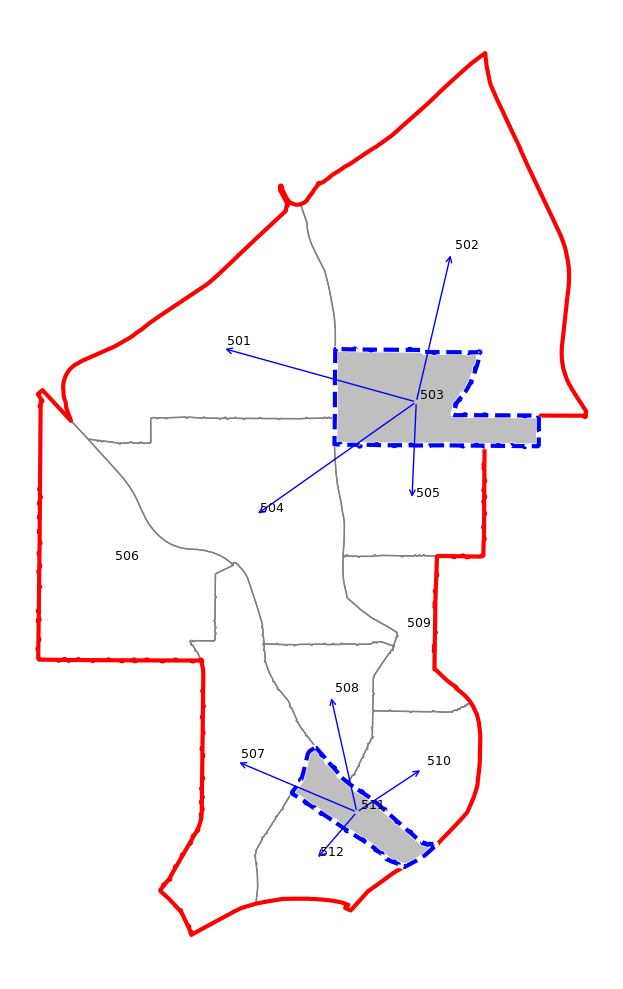

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

beat_list = []
plot_boundary(zone_gdf, beat_list, ax)

for i in range(len(overlap_beats)):
    plot_filtered_gdf_with_arrows(zone_gdf, overlap_beats[i], neighbours_list[i], ax)


# Annotate each polygon with its ‘BEAT’ value
for x, y, label in zip(zone_gdf.geometry.centroid.x, zone_gdf.geometry.centroid.y, zone_gdf['BEAT']):
    ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=9)

ax.axis('off')
plt.tight_layout()
plt.show()

# Hyperlattice Model

In [6]:
from hyperlatticeq import allocation

In [7]:
def get_eta(overlap_beats, beat_list, neighbours_list, beat_dict, I, A):
    def flatten(l):
        flat_list = [item for sublist in l for item in sublist]
        return flat_list
        
    N = len(beat_list)
    eta = np.zeros((N, I))
    server_dict = {}
    idx = -1
    increment = 1
    for beat in beat_list:
        if beat not in flatten(overlap_beats):
            idx += increment
            increment = 1
            eta[beat_dict[beat]][idx] = 1
            server_dict[beat] = idx
        else:
            increment += 1

    for i in range(len(overlap_beats)):
        for region in neighbours_list[i]:
            for beat in overlap_beats[i]:
                eta[beat_dict[beat]][server_dict[region]] = 1 / len(neighbours_list[i])
    return eta

In [8]:
N = len(zone_gdf)
I = N

beat_list = sorted(list(zone_gdf['BEAT']))
geometry_dict = {}
beat_dict = {}
index_dict = {}
for i in range(N):
    geometry_dict[int(zone_gdf.iloc[i]['BEAT'])] = zone_gdf.iloc[i]['geometry']
    beat_dict[beat_list[i]] = i
    index_dict[i] = beat_list[i]

A = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if are_adjacent(geometry_dict[beat_list[i]], geometry_dict[beat_list[j]]):
            A[beat_dict[beat_list[i]]][beat_dict[beat_list[j]]] = 1

eta = get_eta(overlap_beats, beat_list, neighbours_list, beat_dict, I, A)
aloc = allocation(I, lambda_list, A, mu, K=4, inf=5)

In [9]:
mtt, mtt_server, mtt_region = aloc.mean_travel_time_real_case(eta, T)
lat_rho = aloc.perf.rho

In [10]:
print("Mean travel time:", mtt)
print("Individual travel time:")
print(mtt_server)

Mean travel time: 12.631869006693421
Individual travel time:
[13.2385115  13.10252444         nan 13.75176539 12.62095436 12.19640508
 12.20904383 12.18888882 12.01280819 12.27788286         nan 11.99482632]


In [11]:
lat_rho[lat_rho < 1e-5] = 'nan'
print("Workload STD:", np.nanstd(lat_rho))
print("Individual workload:")
print(lat_rho)

Workload STD: 0.060851052356839005
Individual workload:
[0.40733197 0.34830838        nan 0.329257   0.39691461 0.21012139
 0.24289117 0.31366704 0.28781859 0.28656204        nan 0.25839134]
